# Paper Reproduction

## Goal of the project
Reproduce the results from the paper "Predicting the direction of stock market prices using random forest."

## Import Libraries

In [15]:
pip install import-ipynb

Note: you may need to restart the kernel to use updated packages.


In [16]:
import import_ipynb
import technical_indicators as ta

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger

import numpy as np
import random

#Let's make this notebook reproducible 
np.random.seed(42)
random.seed(42)

#import techinal_indicators as ta #https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

## Data
In order to reproduce the same results as the authors, we try to use the same data they used in page 18, table 15.

Since the authors state that they compare these results with other authors using the data from yahoo finance in the period [2010-01-04 to 2014-12-10] we will use the same data. It is not clear which periods they used as traning set and testing set. 



In [19]:
aapl = pd.read_csv('AAPL.csv')
del(aapl['Date'])
del(aapl['Adj Close'])
aapl.head()

,Open,High,Low,Close,Volume,ts_polarity,twitter_volume
0,25.65,26.34,25.50,26.34,270597600,0.070389,1133.0
1,26.44,26.46,25.60,25.68,223164000,0.133635,1430.0
2,25.14,25.59,24.97,25.17,273829600,0.072042,1949.0
3,24.67,25.03,24.11,24.11,324377600,0.074369,2289.0
4,24.64,24.78,24.19,24.24,283192000,0.051595,2235.0


## Exponential smoothing
The authors don't give any guideline for alpha, so let's assume it is 0.9

In [20]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

In [21]:
saapl = get_exp_preprocessing(aapl)
saapl.head() #saapl stands for smoothed aapl

,Open,High,Low,Close,Volume,ts_polarity,twitter_volume
0,25.650000,26.340000,25.500000,26.340000,2.705976e+08,0.070389,1133.000000
1,26.368182,26.449091,25.590909,25.740000,2.274761e+08,0.127885,1403.000000
2,25.261712,25.675135,25.031532,25.226486,2.692360e+08,0.077576,1894.891892
3,24.729118,25.094455,24.202070,24.221548,3.188684e+08,0.074689,2249.624662
4,24.648911,24.811443,24.191207,24.238155,2.867593e+08,0.053904,2236.462335


## Feature Extraction - Technical Indicators
It's not very clear what 'n' should be in most of the indicators, so, we are using several values of 'n'

The indicators used are taken from Peter Bakker at: https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code

note: the Williams %R indicator does not seem to be available in this library yet

In [22]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    #Williams %R is missing
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

## Prepare the data with a prediction horizon of 10 days

In [23]:
data = prepare_data(saapl, 10)

y = data['pred']

#remove the output from the input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]


### Make sure that future data is not used by splitting the data in first 2/3 for training and the last 1/3 for testing

In [36]:
train_size = 2*len(X) // 3

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [37]:
print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))

len X_train 648
len y_train 648
len X_test 324
len y_test 324


## Random Forests

In [38]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

The expected results for a 10 days prediction according to the paper in table 15 for Apple stock should be around 92%

In [35]:
pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')


print(confusion)

precision: 0.87, recall: 0.94, f1: 0.90, accuracy: 0.86
Confusion Matrix
[[ 71  32]
 [ 13 208]]


#### The accuracy results almost match those expected from the paper 86% vs the expected 92%

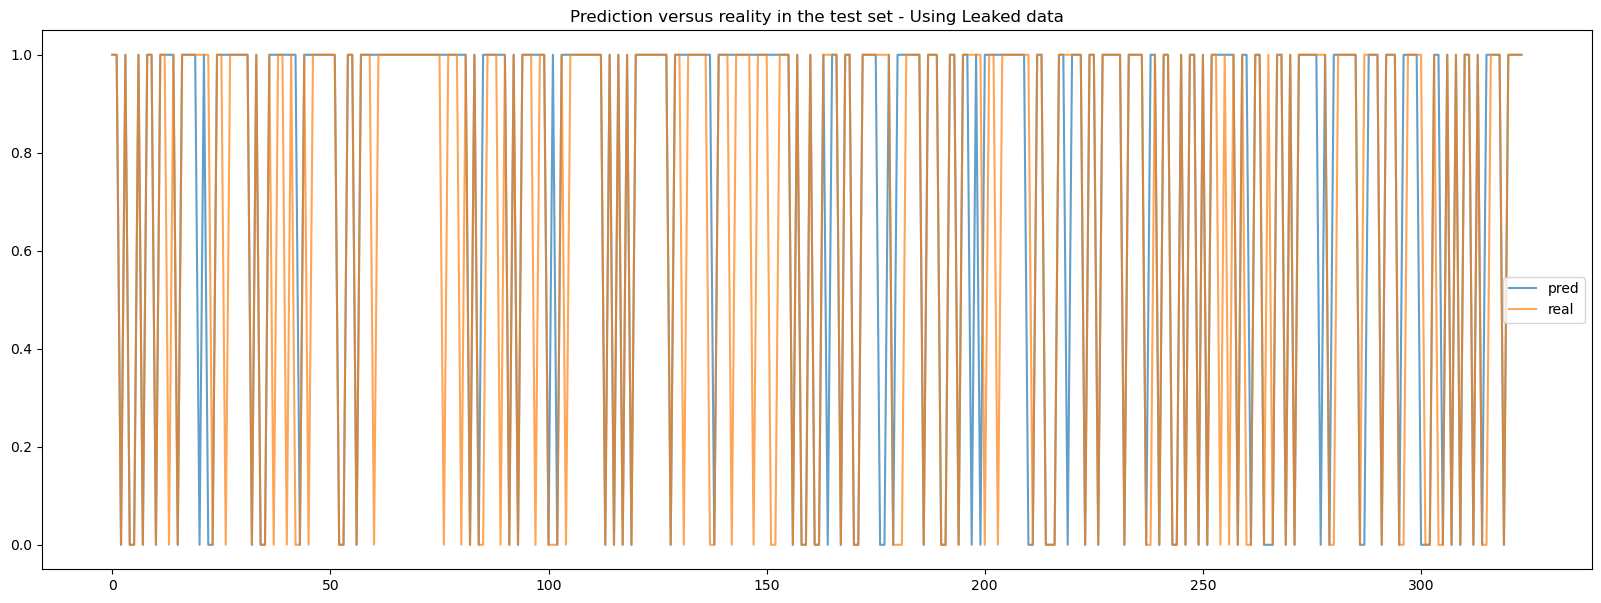

In [33]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real' );
plt.title('Prediction versus reality in the test set - Using Leaked data')
plt.legend();

<Figure size 2000x700 with 0 Axes>

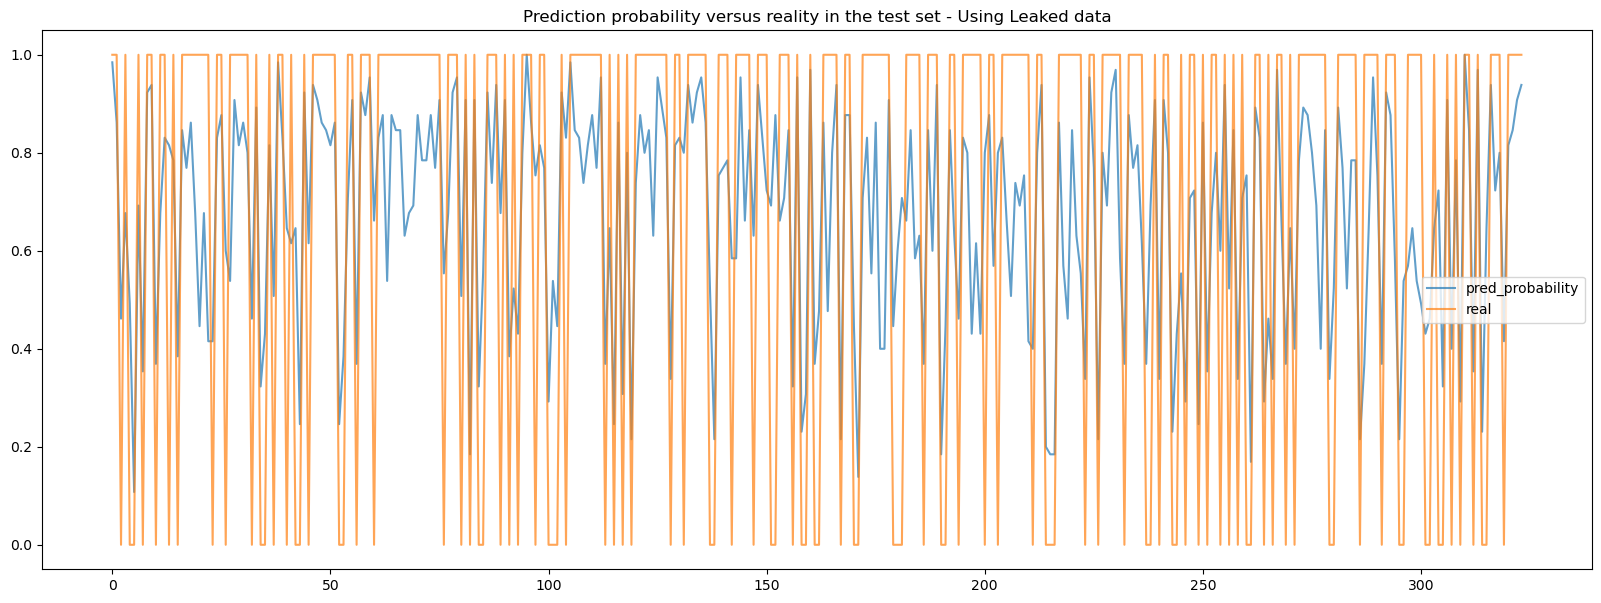

In [34]:
plt.figure(figsize=(20,7))
proba = rf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, alpha = 0.7, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, alpha = 0.7, label='real' );
plt.title('Prediction probability versus reality in the test set - Using Leaked data');
plt.legend();
plt.show();

### Comments on Data Leaked results
The results with the data leakage approach are much more in line with those reported by the paper. In the paper it was reported a 92% accuracy for Apple, while this analysis yields 87% instead. This could be for a number of reasons including:
* the feature Williams %R was not computed
* the value for alpha was set to 0.9, but we don't know what alpha was used
* the value n for several of the technical indicators was not known, and we opted for try several values for 'n'
* more technical indicators were used in the hope that they could contribute to even better results

This analysis seems to indicate that the results from the original paper suffer from data leakage. Please, let me know if you notice any mistake in the analysis / code or if you feel there is something I misunderstood.
